# Linear Regression

## Import libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, ElasticNetCV, ElasticNet
from sklearn.metrics import mean_absolute_error, r2_score, explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Data imputation
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, KFold

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

sns.set_style("whitegrid")

import warnings
warnings.filterwarnings('ignore')

import dengue_utils as dutils

import xgboost as xgb

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Functions:

def simple_linear_regression(X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=83)
    
    reg = LinearRegression(normalize=True).fit(X_train, y_train)

    y_pred = reg.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    ex_var = explained_variance_score(y_test, y_pred)
    
    return mae, r2, ex_var

def enet(X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=83)

    reg = ElasticNet(normalize=False).fit(X_train, y_train)

    y_pred = reg.predict(X_test)
    
    return y_pred, y_test

def get_metrics(y_test, y_pred):
    
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    ex_var = explained_variance_score(y_test, y_pred)
    
    return mae, r2, ex_var

def feature_engineering(df):## Add month of the year

    print("1. Including month of the year from 'week_start_date....'")
    
    if 'week_start_date' in df.columns:
        df['week_start_date'] = pd.to_datetime(df['week_start_date'])
       #df['monthofyear'] = df['week_start_date'].apply(lambda x: x.month)
        
        df = df.drop(['week_start_date'], axis=1)

    # High correlation between ndvi_nw-ndvi-ne and ndvi-sw-ndvi-se
    # Add the mean of each pair that indicates the level of vegetation in the north and south of both cities.

    # Features engineering
    print("2. Including ndvi_north and  ndvi_south from ndvi_nw, ndvi_ne, ndvi_sw, ndvi_se.... ")
    
    if 'ndvi_nw' in df.columns and 'ndvi_ne' in df.columns and 'ndvi_sw' in df.columns and 'ndvi_se' in df.columns:
    
        df['ndvi_north'] = df[['ndvi_nw', 'ndvi_ne']].mean(axis=1)
        df['ndvi_south'] = df[['ndvi_sw', 'ndvi_se']].mean(axis=1)
        
        df = df.drop(['ndvi_sw', 'ndvi_nw', 'ndvi_ne', 'ndvi_se'], axis=1)

    # Conversion kelvin to celsius
    print("3. Temperature units conversion: kelvin to celsius from some features...")
    df = dutils.temperature_conversion(df)
    
    # City to numeric
    
    df['city_code'] = np.where(df['city'] == 'sj', 0, 1)
    # Drop temperature features
   # df = df.drop(['reanalysis_dew_point_temp_c', 'reanalysis_max_air_temp_c', 
   #               'reanalysis_max_air_temp_c', 'reanalysis_min_air_temp_c',
   #               'reanalysis_avg_temp_c', 'reanalysis_tdtr_c', 'station_max_temp_c',
   #               'station_max_temp_c', 'station_diur_temp_rng_c', 'station_avg_temp_c',
   #              'station_min_temp_c', 'reanalysis_specific_humidity_g_per_kg'], axis=1)
   # 
    return df


In [3]:
# Load dataset

features_train = pd.read_csv('dengue_features_train.csv')
labels_train   = pd.read_csv('dengue_labels_train.csv')

features_test = pd.read_csv('dengue_features_test.csv')

# Join train labes and features
input_train_dataset = features_train.merge(labels_train, 
                                           left_on = ['city', 'year', 'weekofyear'], 
                                           right_on = ['city', 'year', 'weekofyear'],
                                           how = 'inner')



In [4]:
input_train_dataset.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [5]:
input_train_dataset['week_start_date'] = pd.to_datetime(input_train_dataset['week_start_date'])
input_train_dataset.dtypes

city                                             object
year                                              int64
weekofyear                                        int64
week_start_date                          datetime64[ns]
ndvi_ne                                         float64
ndvi_nw                                         float64
ndvi_se                                         float64
ndvi_sw                                         float64
precipitation_amt_mm                            float64
reanalysis_air_temp_k                           float64
reanalysis_avg_temp_k                           float64
reanalysis_dew_point_temp_k                     float64
reanalysis_max_air_temp_k                       float64
reanalysis_min_air_temp_k                       float64
reanalysis_precip_amt_kg_per_m2                 float64
reanalysis_relative_humidity_percent            float64
reanalysis_sat_precip_amt_mm                    float64
reanalysis_specific_humidity_g_per_kg           

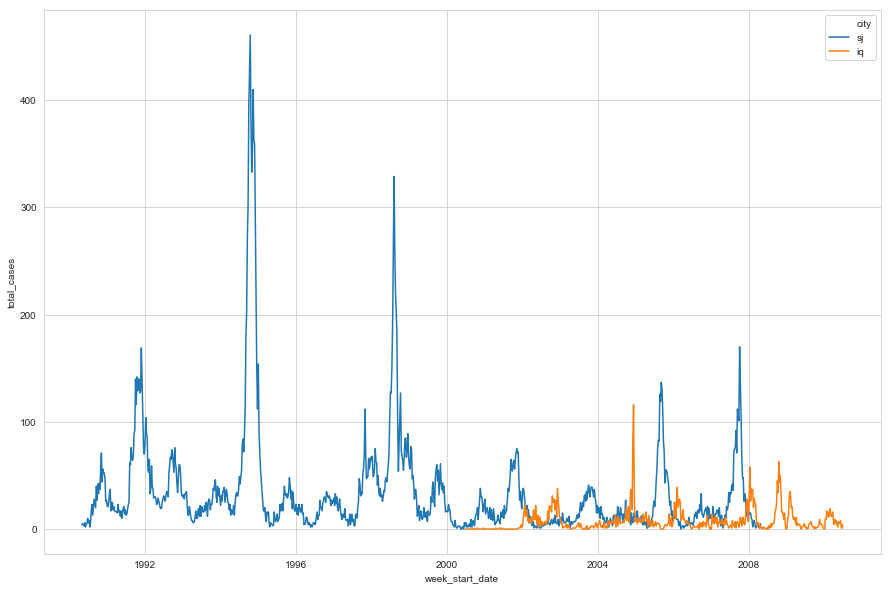

In [6]:
f, ax = plt.subplots(figsize=(15, 10))

# Plot the responses for different events and regions
sns.lineplot(x="week_start_date", y="total_cases", hue="city",
             data=input_train_dataset)

In [7]:
print(input_train_dataset[input_train_dataset['city'] == 'iq']['week_start_date'].max())
print(input_train_dataset[input_train_dataset['city'] == 'iq']['week_start_date'].min())

2010-06-25 00:00:00
2000-07-01 00:00:00


In [8]:
print(input_train_dataset[input_train_dataset['city'] == 'sj']['week_start_date'].max())
print(input_train_dataset[input_train_dataset['city'] == 'sj']['week_start_date'].min())

2008-04-22 00:00:00
1990-04-30 00:00:00


In [9]:
input_train_dataset = input_train_dataset[input_train_dataset['week_start_date'] >= '2000-07-01']
input_train_dataset = input_train_dataset[input_train_dataset['week_start_date'] <= '2008-04-22']

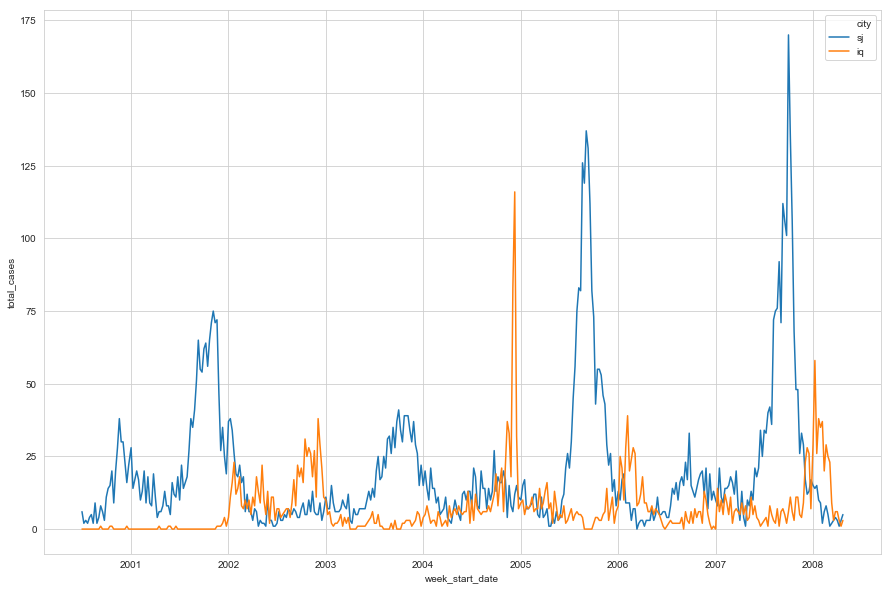

In [10]:
f, ax = plt.subplots(figsize=(15, 10))

# Plot the responses for different events and regions
sns.lineplot(x="week_start_date", y="total_cases", hue="city",
             data=input_train_dataset)

## Preprocessing

In [11]:
def preprocessing(dataset, train=True):
    # --------------------------------------
    # Feature engineering
    #---------------------------------------

    dataset = feature_engineering(dataset)
    label = 'total_cases'

    # --------------------------------------
    # Remove outiers
    #---------------------------------------

    # Remove outliers
    #for feature in  dataset.columns:
    #    dataset[feature] = dutils.remove_outliers_iqr(dataset, feature, exclude = ['total_cases'])

    #dutils.printlog("Remove outliers " + str(dataset.shape)) 
    # Filling the outliers gaps
    #dataset = dataset.dropna().drop_duplicates()

    # --------------------------------------
    # Split data and label
    #---------------------------------------

    dataset_label = []
    if label in dataset.columns:
        # Split label and features
        dataset_label  = dataset[label].copy()
        dataset = dataset.drop([label], axis=1)

    # Drop city column because is not numeric and label column (total_cases)
    features_lreg = dataset.columns.drop(['city'])

    dataset = dataset[features_lreg]

    # --------------------------------------
    # Scaling and data imputation
    #---------------------------------------

    # Data imputation
    imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
    dataset_train_imp = pd.DataFrame(imp.fit_transform(dataset))

    dutils.printlog("Data imputation " + str(dataset.shape)) 

    # Set columns name
    dataset_train_imp.columns = dataset.columns
    dataset_train_imp.index   = dataset.index


    # Scale data (features)
    scaler = StandardScaler().fit(dataset_train_imp)
    dataset = pd.DataFrame(scaler.transform(dataset_train_imp), columns = dataset_train_imp.columns)

    dutils.printlog("Scale " + str(dataset.shape)) 
    
    if train:
        dataset_label = dataset_label.reset_index()
        dataset_label = dataset_label['total_cases']
        dataset['total_cases'] = dataset_label.copy()
        
    return dataset

# Train model for eah city 

In [12]:
predictions = pd.DataFrame()
submision_predictions = pd.DataFrame()

cities = input_train_dataset['city'].unique()

for city in cities:

    train_dataset_city = input_train_dataset[input_train_dataset['city'].isin([city])]
    
    dutils.printlog("Preprocessing " + str(train_dataset_city.shape)) 
    dataset_train = preprocessing(train_dataset_city)
    
    dataset_label = dataset_train['total_cases']
    dataset_train = dataset_train.drop('total_cases', axis=1)

    # --------------------------------------
    # Split dataset in test and training
    #---------------------------------------
    X_train, X_test, y_train, y_test = train_test_split(dataset_train, 
                                                        dataset_label, 
                                                        test_size = 0.2, 
                                                        random_state=83)

    # --------------------------------------
    # Training models
    #---------------------------------------

    xgb_res = xgb.XGBRegressor(objective="reg:linear", random_state=83)

    #parameters = {'nthread':[2], #when use hyperthread, xgboost may become slower
    #              'objective':['reg:linear'],
    #              'learning_rate': [0.03, 0.05, 0.07], #so called `eta` value
    #              'max_depth': [3, 4, 5, 6, 7],
    #              'min_child_weight': [4, 5, 6],
    #              'silent': [1],
    #              'subsample': [0.6, 0.7, 0.8],
    #              'colsample_bytree': [0.6, 0.7, 0.8],
    #              'n_estimators': [500, 1000, 2000]}
#
    #xgb_grid = GridSearchCV(xgb_res,
    #                        parameters,
    #                        cv = 2,
    #                        n_jobs = 5,
    #                        verbose=True)

    xgb_res.fit(X_train, y_train)
    
    y_pred_xgb = xgb_res.predict(X_test)
    
    res = pd.DataFrame({'y_pred_xgb':y_pred_xgb, 'y_test':y_test})
    res['city'] = city
    predictions = pd.concat([predictions, res], axis=0)
    
    
    features_test_city = features_test[features_test['city'].isin([city])]

    dutils.printlog("Preprocessing test data" + str(features_test_city.shape)) 
    dataset_test = preprocessing(features_test_city, train=False)

    y_predictions = xgb_res.predict(dataset_test)
    features_test_city['total_cases'] = np.round(y_predictions).astype(int)

    submision_predictions = pd.concat([submision_predictions, features_test_city], axis=0)

20190415 - 12:M:42: Preprocessing (407, 25)
1. Including month of the year from 'week_start_date....'
2. Including ndvi_north and  ndvi_south from ndvi_nw, ndvi_ne, ndvi_sw, ndvi_se.... 
3. Temperature units conversion: kelvin to celsius from some features...
20190415 - 12:M:42: Temperature conversion: kelvin to celsius reanalysis_air_temp_k to reanalysis_air_temp_c
20190415 - 12:M:42: Temperature conversion: kelvin to celsius reanalysis_dew_point_temp_k to reanalysis_dew_point_temp_c
20190415 - 12:M:42: Temperature conversion: kelvin to celsius reanalysis_max_air_temp_k to reanalysis_max_air_temp_c
20190415 - 12:M:42: Temperature conversion: kelvin to celsius reanalysis_min_air_temp_k to reanalysis_min_air_temp_c
20190415 - 12:M:42: Temperature conversion: kelvin to celsius reanalysis_avg_temp_k to reanalysis_avg_temp_c
20190415 - 12:M:42: Temperature conversion: kelvin to celsius reanalysis_tdtr_k to reanalysis_tdtr_c
20190415 - 12:M:42: Data imputation (407, 21)
20190415 - 12:M:42: 

(5.630675927894871, 0.5997862687510742, 0.6029511918938335)


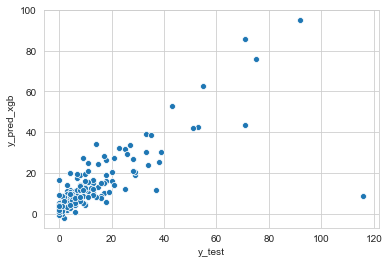

In [13]:
metrics_xgb = get_metrics(predictions.y_test, predictions.y_pred_xgb)
print(metrics_xgb)

#df = pd.concat([df_test, y_pred_xgb], axis=1)

ax = sns.scatterplot(x="y_test", y="y_pred_xgb", data=predictions)

In [48]:
submision_predictions[['city', 'year', 'weekofyear', 'total_cases']].to_csv("./submission_20190415.3.csv", index=False)

In [49]:
submision_predictions.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,...,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2,-1
1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,...,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3,4
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,...,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0,-1
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,...,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3,1
4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,...,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1,-3


# Result exploration

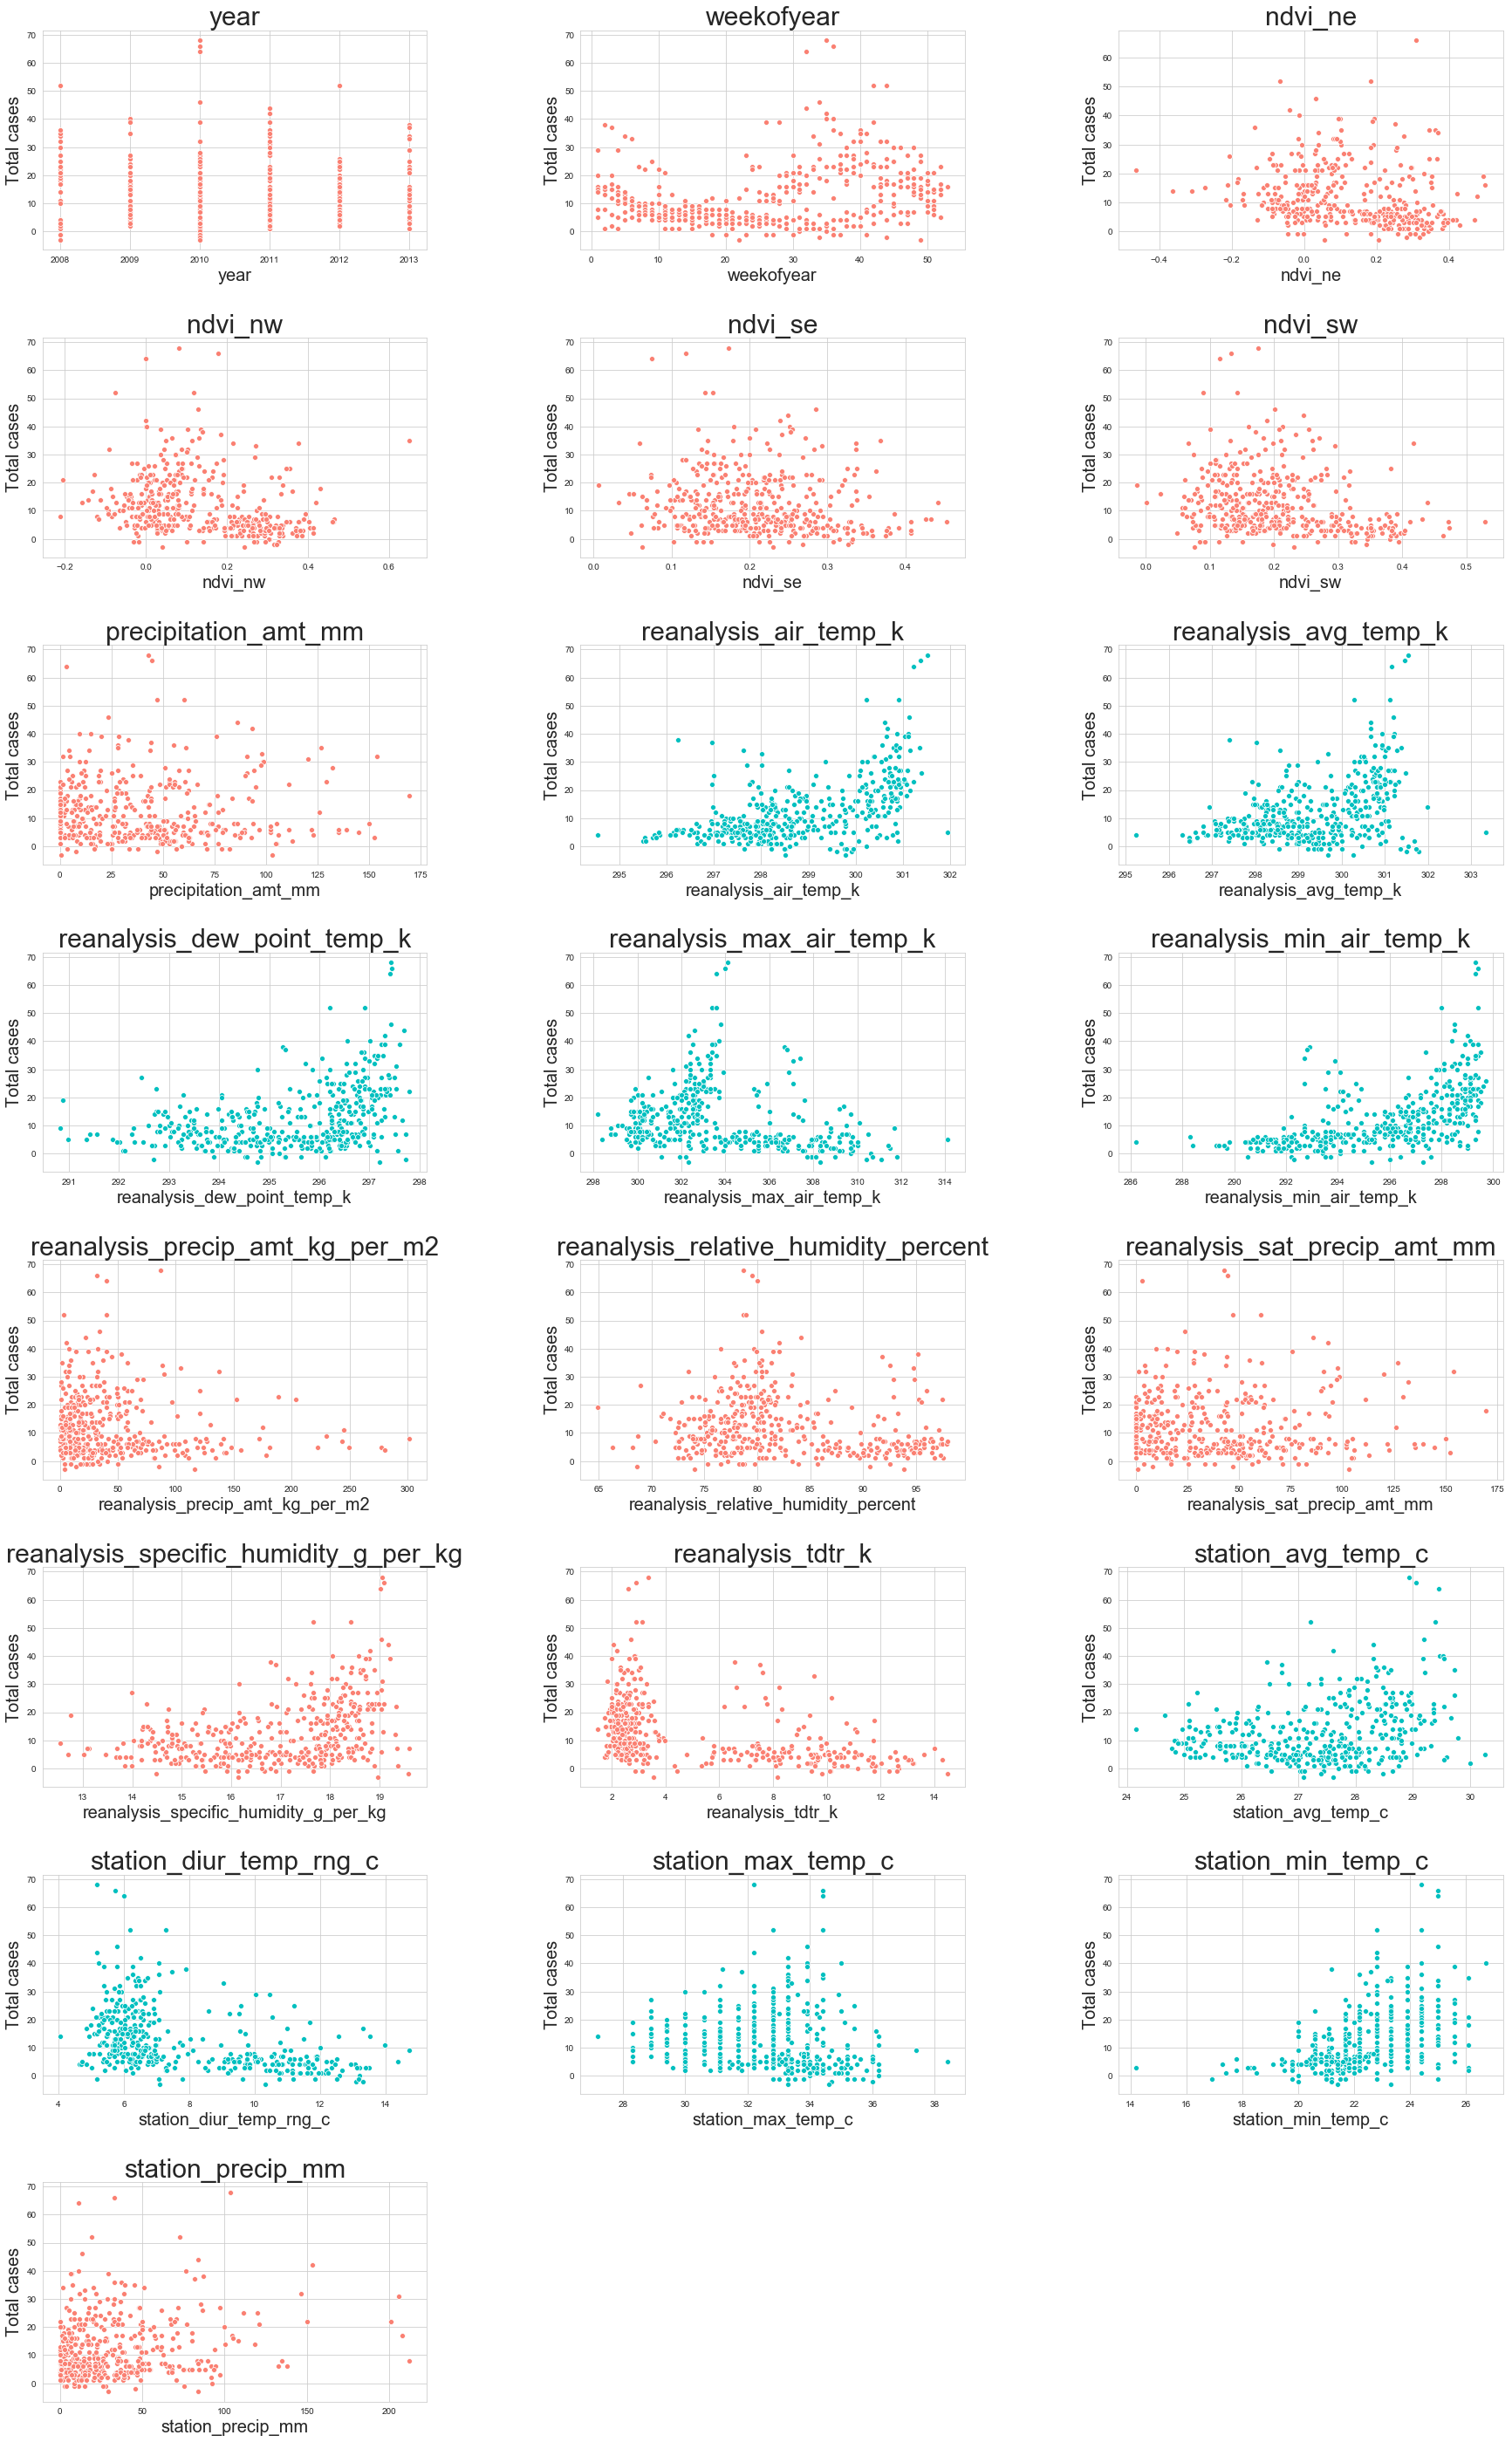

In [50]:
features = submision_predictions.columns.drop(['city', 'total_cases','week_start_date'])

fig = plt.figure(figsize=(30, 50))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, column in enumerate(features):

    ax = fig.add_subplot(8, 3, i+1)
    
    dot_color = 'salmon'
    if "temp" in column:
        dot_color = 'c'
    
    sns.scatterplot(x=column, y="total_cases", data=submision_predictions, color=dot_color)
    ax.axes.set_title(column,fontsize=30)
    ax.set_xlabel(column,fontsize=20)
    ax.set_ylabel("Total cases",fontsize=20)


In [35]:
submision_predictions.describe().T

,count,mean,std,min,25%,50%,75%,max
year,416.0,2010.766827,1.434835,2008.000000,2010.000000,2011.000000,2012.000000,2013.000000
weekofyear,416.0,26.439904,14.978257,1.000000,13.750000,26.000000,39.000000,53.000000
ndvi_ne,373.0,0.126050,0.164353,-0.463400,-0.001500,0.110100,0.263329,0.500400
ndvi_nw,405.0,0.126803,0.141420,-0.211800,0.015975,0.088700,0.242400,0.649000
ndvi_se,415.0,0.207702,0.079102,0.006200,0.148670,0.204171,0.254871,0.453043
ndvi_sw,415.0,0.201721,0.092028,-0.014671,0.134079,0.186471,0.253243,0.529043
precipitation_amt_mm,414.0,38.354324,35.171126,0.000000,8.175000,31.455000,57.772500,169.340000
reanalysis_air_temp_k,414.0,298.818295,1.469501,294.554286,297.751429,298.547143,300.240357,301.935714
reanalysis_avg_temp_k,414.0,299.353071,1.306233,295.235714,298.323214,299.328571,300.521429,303.328571
reanalysis_dew_point_temp_k,414.0,295.419179,1.523099,290.818571,294.335714,295.825000,296.643571,297.794286


In [51]:
input_train_dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
year,814.0,2003.911548,2.294877,2000.000000,2002.000000,2004.000000,2006.000000,2008.000000
weekofyear,814.0,26.538084,15.114419,1.000000,13.000000,27.000000,40.000000,53.000000
ndvi_ne,739.0,0.156670,0.156105,-0.406250,0.033275,0.178429,0.281106,0.493400
ndvi_nw,798.0,0.134550,0.135552,-0.456100,0.031725,0.140364,0.237015,0.428771
ndvi_se,810.0,0.216000,0.078283,-0.015533,0.161761,0.208051,0.266054,0.473400
ndvi_sw,810.0,0.216351,0.089315,-0.063457,0.153346,0.205500,0.272979,0.546017
precipitation_amt_mm,810.0,51.016469,45.179284,0.000000,16.005000,44.365000,75.330000,390.600000
reanalysis_air_temp_k,810.0,298.685483,1.465700,294.635714,297.640000,298.538571,299.916786,302.200000
reanalysis_avg_temp_k,810.0,299.378386,1.306857,294.892857,298.407143,299.346429,300.500000,302.928571
reanalysis_dew_point_temp_k,810.0,295.293113,1.488878,290.088571,294.168571,295.689286,296.527143,297.852857
